In [1]:
# ===========================

In [2]:
# Install and Import working libraries

In [3]:
# ===========================

In [4]:
!pip install kagglehub --quiet

In [5]:
import kagglehub

In [6]:
import os

In [7]:
import numpy as np

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [13]:
from tensorflow.keras.models import Sequential

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
import joblib

In [17]:
# ===========================

In [18]:
# Download EuroSAT RGB Dataset

In [19]:
# ===========================

In [20]:
path = kagglehub.dataset_download("waseemalastal/eurosat-rgb-dataset")

100%|██████████| 89.9M/89.9M [00:04<00:00, 19.0MB/s]

Extracting files...


In [21]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/waseemalastal/eurosat-rgb-dataset/versions/1


In [22]:
# Dataset directory (kagglehub auto extracts files)

In [23]:
base_dir = os.path.join(path, "EuroSAT_RGB")

In [24]:
print("Detected base image directory:", base_dir)

Detected base image directory: /root/.cache/kagglehub/datasets/waseemalastal/eurosat-rgb-dataset/versions/1/EuroSAT_RGB


In [25]:
# ===========================

In [26]:
# Inspect classes

In [27]:
# ===========================

In [28]:
print("\nLand use classes and sample files:")
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        sample_files = os.listdir(folder_path)[:5]
        print(f"{folder}: {len(os.listdir(folder_path))} images, sample: {sample_files}")


Land use classes and sample files:
Residential: 3000 images, sample: ['Residential_2398.jpg', 'Residential_2469.jpg', 'Residential_1694.jpg', 'Residential_2813.jpg', 'Residential_462.jpg']
River: 2500 images, sample: ['River_714.jpg', 'River_84.jpg', 'River_812.jpg', 'River_1130.jpg', 'River_1557.jpg']
Pasture: 2000 images, sample: ['Pasture_1119.jpg', 'Pasture_1803.jpg', 'Pasture_1367.jpg', 'Pasture_1869.jpg', 'Pasture_1692.jpg']
PermanentCrop: 2500 images, sample: ['PermanentCrop_2058.jpg', 'PermanentCrop_298.jpg', 'PermanentCrop_1911.jpg', 'PermanentCrop_140.jpg', 'PermanentCrop_612.jpg']
AnnualCrop: 3000 images, sample: ['AnnualCrop_400.jpg', 'AnnualCrop_152.jpg', 'AnnualCrop_1080.jpg', 'AnnualCrop_653.jpg', 'AnnualCrop_2206.jpg']
Forest: 3000 images, sample: ['Forest_903.jpg', 'Forest_2141.jpg', 'Forest_1050.jpg', 'Forest_510.jpg', 'Forest_1506.jpg']
HerbaceousVegetation: 3000 images, sample: ['HerbaceousVegetation_2653.jpg', 'HerbaceousVegetation_1477.jpg', 'HerbaceousVegetation

In [29]:
# Inspect Dataset and Display Samples

In [30]:
class_counts = {}

In [31]:
image_sizes = {}

In [32]:
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        class_counts[class_name] = len(images)
        if len(images) > 0:
            with Image.open(os.path.join(class_path, images[0])) as img:
                image_sizes[class_name] = img.size + (len(img.getbands()),)

In [33]:
total_images = sum(class_counts.values())

In [34]:
print("\nClass distribution (% of total images):")
for class_name, count in class_counts.items():
    percent = (count / total_images) * 100
    print(f"{class_name}: {count} images ({percent:.2f}%) - sample size: {image_sizes[class_name]}")


Class distribution (% of total images):
Residential: 3000 images (11.11%) - sample size: (64, 64, 3)
River: 2500 images (9.26%) - sample size: (64, 64, 3)
Pasture: 2000 images (7.41%) - sample size: (64, 64, 3)
PermanentCrop: 2500 images (9.26%) - sample size: (64, 64, 3)
AnnualCrop: 3000 images (11.11%) - sample size: (64, 64, 3)
Forest: 3000 images (11.11%) - sample size: (64, 64, 3)
HerbaceousVegetation: 3000 images (11.11%) - sample size: (64, 64, 3)
SeaLake: 3000 images (11.11%) - sample size: (64, 64, 3)
Industrial: 2500 images (9.26%) - sample size: (64, 64, 3)
Highway: 2500 images (9.26%) - sample size: (64, 64, 3)


In [35]:
# Show sample images

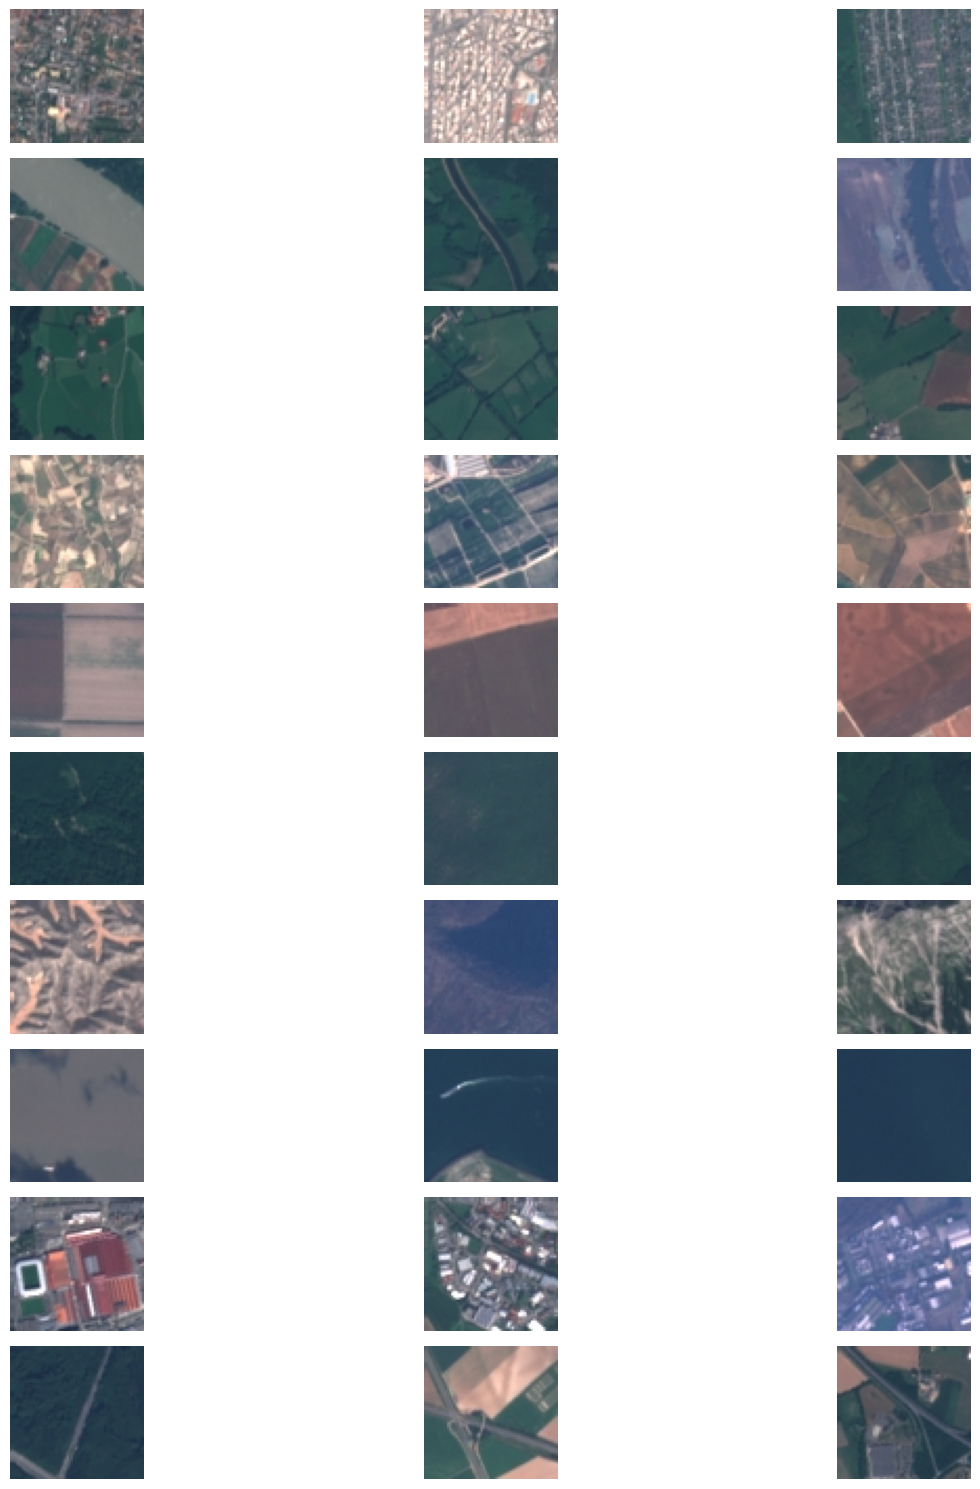

In [36]:
plt.figure(figsize=(15, 15))
row = 0
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        sample_images = os.listdir(class_path)[:3]
        for img_file in sample_images:
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                row += 1
                plt.subplot(len(class_counts), 3, row)
                plt.imshow(img)
                plt.axis('off')
                if row % 3 == 1:
                    plt.ylabel(class_name, rotation=0, labelpad=50, fontsize=12, va='center')
plt.tight_layout()
plt.show()

In [37]:
# ===========================

In [38]:
# Prepare Data for CNN

In [39]:
# ===========================

In [40]:
img_size = (64, 64)

In [41]:
classes = sorted(os.listdir(base_dir))

In [42]:
images, labels = [], []

In [43]:
for idx, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=img_size)
        images.append(img_to_array(img) / 255.0)
        labels.append(idx)

In [44]:
X = np.array(images, dtype='float32')

In [45]:
y = to_categorical(labels, num_classes=len(classes))

In [46]:
# Train/Validation split (80/20)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 21600, Validation samples: 5400


In [49]:
print(f"Image shape: {X_train.shape[1:]}, Number of classes: {y_train.shape[1]}")

Image shape: (64, 64, 3), Number of classes: 10


In [50]:
# ===========================

In [51]:
# Build and Compile CNN

In [52]:
# ===========================

In [53]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# ===========================

In [57]:
# Train the Model (3 Epochs)

In [58]:
# ===========================

In [59]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                                   height_shift_range=0.1, horizontal_flip=True)

In [60]:
val_datagen = ImageDataGenerator()

In [61]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [62]:
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [64]:
history = model.fit(train_generator, validation_data=val_generator, epochs=3, callbacks=[early_stop])

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.3152 - loss: 1.7873 - val_accuracy: 0.5711 - val_loss: 1.1832
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.5448 - loss: 1.2469 - val_accuracy: 0.6328 - val_loss: 1.0491
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.6255 - loss: 1.0620 - val_accuracy: 0.7141 - val_loss: 0.8170


In [65]:
# ===========================

In [66]:
# Save the trained model

In [67]:
# ===========================

In [68]:
joblib.dump(model, 'eurosat_cnn_model.joblib')

['eurosat_cnn_model.joblib']

In [69]:
print("Model saved as eurosat_cnn_model.joblib")

Model saved as eurosat_cnn_model.joblib


In [70]:
# ===========================

In [71]:
# Evaluate and Visualize

In [72]:
# ===========================

In [73]:
val_loss, val_acc = model.evaluate(val_generator)

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7155 - loss: 0.8112


In [74]:
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.8170, Validation Accuracy: 0.7141


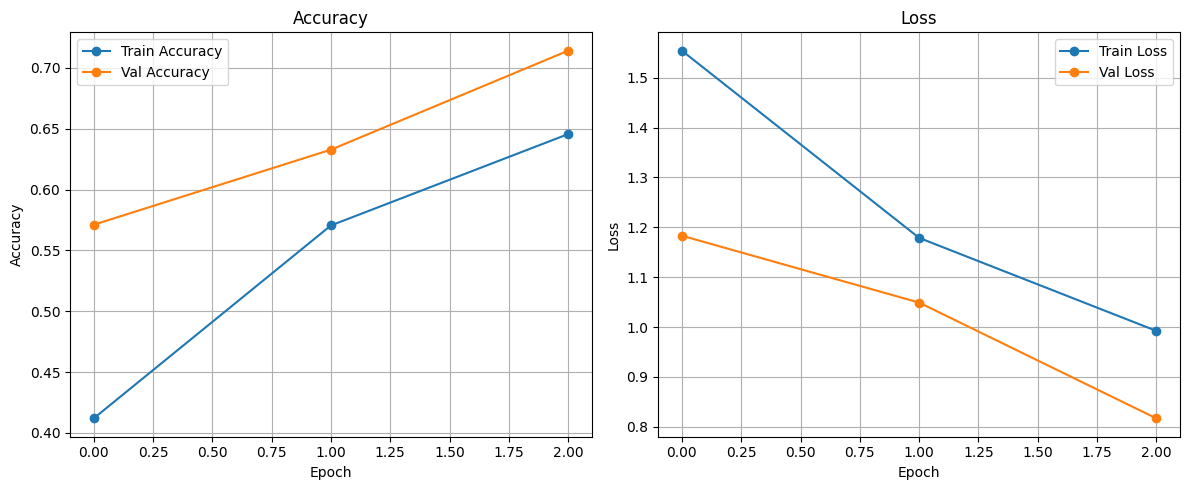

In [75]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
# ===========================

In [77]:
# Predict and Display Samples

In [78]:
# ===========================

In [79]:
indices = np.random.choice(len(X_val), 12, replace=False)

In [80]:
sample_images = X_val[indices]

In [81]:
sample_labels = y_val[indices]

In [82]:
pred_probs = model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


In [83]:
pred_classes = np.argmax(pred_probs, axis=1)

In [84]:
true_classes = np.argmax(sample_labels, axis=1)

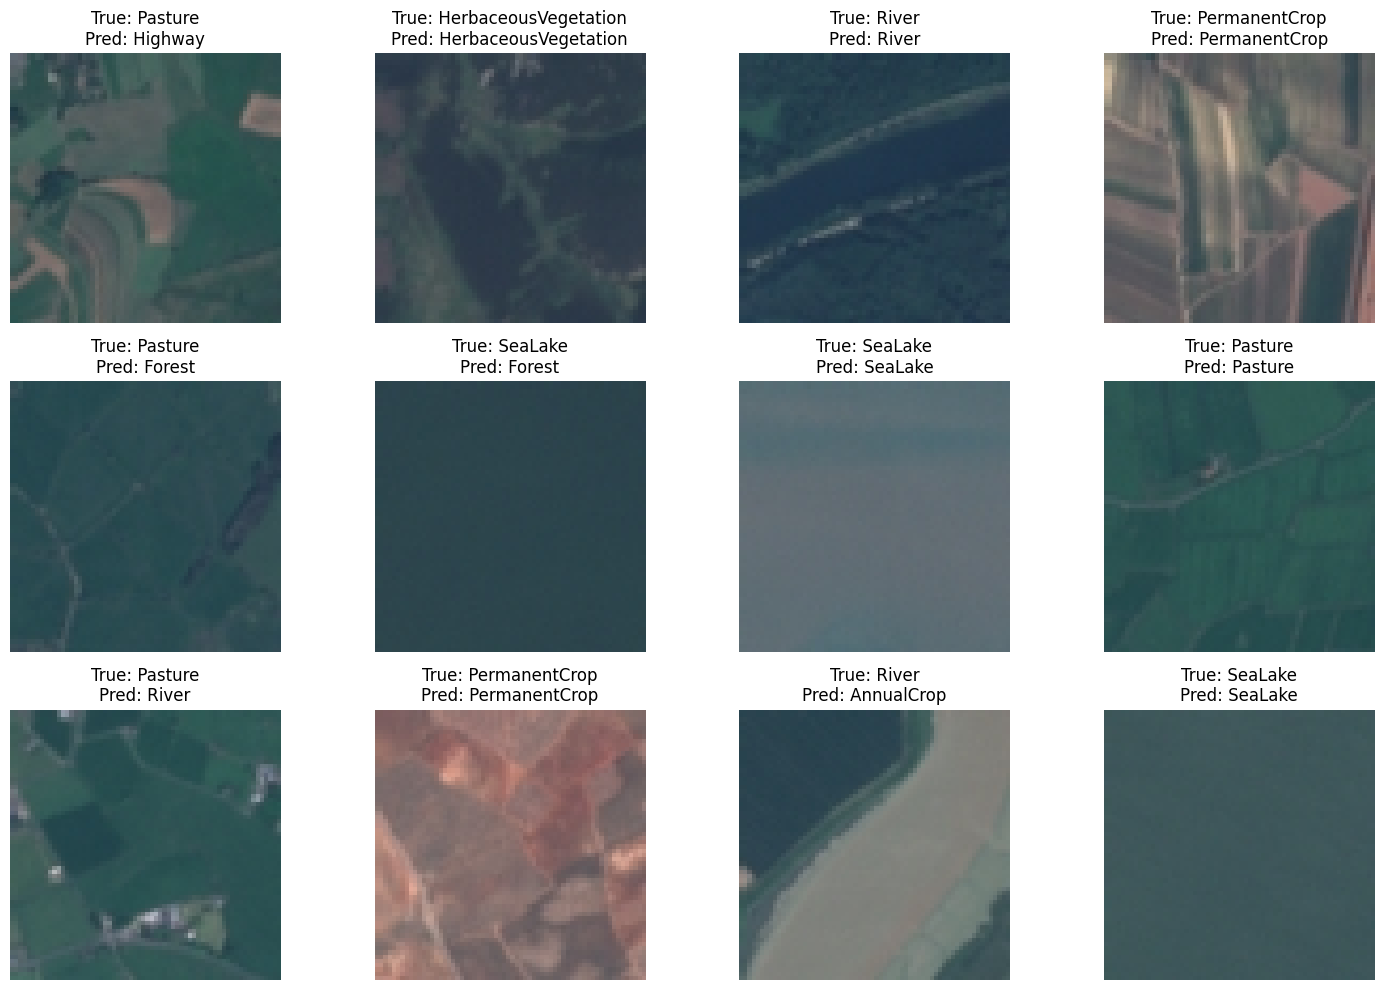

In [85]:
plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {classes[true_classes[i]]}\nPred: {classes[pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()